# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. My code for training the agent

The training function will train a pair of agents to play tennis. The rewards will be added up for max time steps and it will yield 2 scores. we then take the maximum of these 2 scores. After each episode, it will be stored to 'scores' variable and be averaged over 100 episodes. The environment is considered solved, when the average of scores is at leat +0.5

In [5]:
!pip install fastprogress

In [6]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from ddpg_agent import Agent
from tqdm import tqdm
from fastprogress import progress_bar, master_bar

In [7]:
# initialize agents
agent0 = Agent(state_size, action_size)
agent1 = Agent(state_size, action_size)

In [9]:
def ddpg_tennis(n_episodes=1500, max_t=1000, train_mode=True):
    scores_deque = deque(maxlen=100)
    scores_all = []    
    mean_avg_scores = []
    achieved = False
    
    mb = master_bar(range(1, n_episodes+1))
    for i_episode in mb:
        env_info = env.reset(train_mode)[brain_name]
        states = env_info.vector_observations
        agent0.reset()
        agent1.reset()
        scores = np.zeros(num_agents)
        for t in progress_bar(range(max_t), parent=mb):
            action0 = agent0.act(states[0], add_noise=True)    
            action1 = agent0.act(states[1], add_noise=True)    
            env_info = env.step([action0, action1])[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            agent0.step(states[0], action0, rewards[0], next_states[0], dones[0])
            agent1.step(states[1], action1, rewards[1], next_states[1], dones[1])
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.max(scores))
        scores_all.append(np.max(scores))
        mean_avg_scores.append(np.mean(scores_deque))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore {:.2f}\tAverage Score {:.2f}'.format(i_episode, np.max(scores), np.mean(scores_deque)))
        
        if mean_avg_scores[-1]>=0.5 and achieved is False:
            print('Score of', mean_avg_scores[-1], 'achieved in', i_episode, 'episodes')
            torch.save(agent0.actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(agent0.critic_local.state_dict(), 'checkpoint_critic0.pth')
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            achieved = True
        
    return scores_all, mean_avg_scores

In [10]:
scores, avg_scores = ddpg_tennis()

Episode 100	Score 0.00	Average Score 0.00
Episode 200	Score 0.00	Average Score 0.03
Episode 300	Score 0.09	Average Score 0.07
Episode 400	Score 0.00	Average Score 0.03
Episode 500	Score 0.10	Average Score 0.05
Episode 600	Score 0.00	Average Score 0.04
Episode 700	Score 0.00	Average Score 0.04
Episode 800	Score 0.10	Average Score 0.09
Episode 900	Score 0.09	Average Score 0.13
Episode 1000	Score 0.10	Average Score 0.13
Episode 1100	Score 0.19	Average Score 0.15
Episode 1200	Score 0.10	Average Score 0.17
Score of 0.517700007726 achieved in 1243 episodes
Episode 1300	Score 0.20	Average Score 1.15
Episode 1400	Score 0.10	Average Score 0.88
Episode 1500	Score 1.00	Average Score 1.06


### 4. Plotting the score achieved in these 1500 episodes

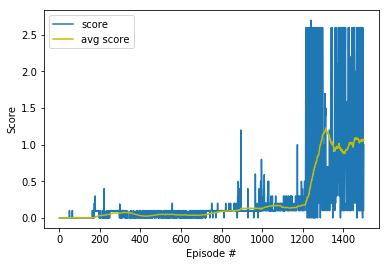

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='score')
plt.plot(np.arange(1, len(scores)+1), avg_scores, c='y', label='avg score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

In [12]:
env.close()